In [5]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam(model, input_image, target_layer):
    model.eval()
    gradients = []
    
    def save_gradient(grad):
        gradients.append(grad)
    
    activations = None
    
    def forward_hook(module, input, output):
        nonlocal activations
        if isinstance(output, tuple):
            activations = output[0]  # Access the first element in the tuple if output is a tuple
        else:
            activations = output
        activations.register_hook(save_gradient)
    
    hook = target_layer.register_forward_hook(forward_hook)
    
    outputs = model(input_image)
    logits = outputs.logits
    
    target_class = logits.argmax(dim=1).item()
    loss = logits[0, target_class]
    
    model.zero_grad()
    loss.backward()
    
    # Check the shape of the gradients
    if len(gradients) > 0:
        pooled_gradients = torch.mean(gradients[0], dim=[0])  # Average across spatial dimensions if needed
    else:
        raise ValueError("No gradients found. Ensure the model is set correctly.")
    
    # Ensure activations have the correct shape before proceeding
    if activations is not None:
        if len(activations.shape) == 3:  # Handle activations of shape (batch_size, num_features, sequence_length)
            for i in range(pooled_gradients.size(0)):
                activations[:, i, :] *= pooled_gradients[i]  # Adjust this if activations have 3 dimensions
        elif len(activations.shape) == 4:  # Typical shape for 2D features
            for i in range(pooled_gradients.size(0)):
                activations[:, i, :, :] *= pooled_gradients[i]  # Adjust accordingly
        else:
            raise ValueError("Unexpected shape of activations.")
        
        # Create the heatmap
        heatmap = torch.mean(activations, dim=1).squeeze().detach().cpu().numpy()
        
        # Post-process heatmap
        heatmap = np.maximum(heatmap, 0)
        heatmap /= heatmap.max()
    else:
        raise ValueError("No activations found. Check if the hook was registered correctly.")

    
    hook.remove()
    return heatmap


In [6]:
from PIL import Image
from transformers import ViTImageProcessor, ViTForImageClassification

# Load and preprocess image
output_dir = "google/vit-base-patch16-224-in21k"
image = Image.open("example-leaf.jpg")
processor = ViTImageProcessor.from_pretrained(output_dir)
input_tensor = processor(images=image, return_tensors="pt")["pixel_values"]

# Load your trained model
model = ViTForImageClassification.from_pretrained(output_dir)
model.eval()


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [7]:
target_layer = model.vit.encoder.layer[-1]  # Last transformer block in ViT


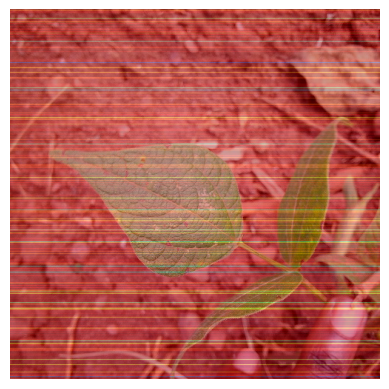

In [8]:
# Get Grad-CAM heatmap
heatmap = grad_cam(model, input_tensor, target_layer)

# Resize heatmap to match image dimensions
heatmap = cv2.resize(heatmap, (image.width, image.height))

# Convert image to numpy array and overlay heatmap
image_np = np.array(image)
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Combine heatmap with image
overlayed_image = heatmap * 0.4 + image_np * 0.6
plt.imshow(overlayed_image.astype("uint8"))
plt.axis("off")
plt.show()
